In [1]:
# %% [markdown]
# # 🔌 Power Plant Energy Output Prediction
# 
# A machine learning project to predict the net hourly electrical energy output (PE) based on environmental variables.
# 
# **Features**:
# - Temperature (T)
# - Exhaust Vacuum (V)
# - Ambient Pressure (AP)
# - Relative Humidity (RH)
# 
# **Target**:
# - Net hourly electrical energy output (PE)

# %%
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# %%
# Load dataset
df = pd.read_csv('power_plant_data.csv')  # Replace with your actual file name
df.head()

# %% [markdown]
# ## 🔍 Exploratory Data Analysis

# %%
# Basic statistics
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


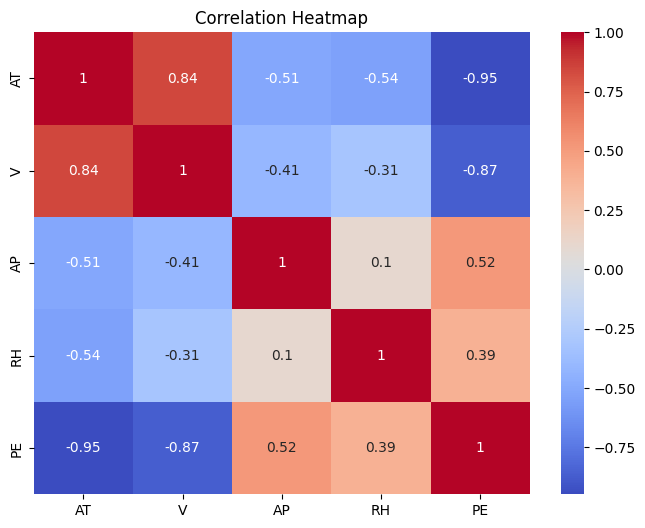

In [3]:
# %%
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [5]:
# %% [markdown]
# ## ✂️ Data Preprocessing

# %%
# Features and target
X = df[['AT', 'V', 'AP', 'RH']]
y = df['PE']

In [6]:
# Train-validation-test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# %%
print(f"Train+Val Size: {X_trainval.shape}")
print(f"Test Size: {X_test.shape}")

Train+Val Size: (7654, 4)
Test Size: (1914, 4)


In [7]:
# %% [markdown]
# ## 📈 Model 1: Linear Regression

# %%
lr_model = LinearRegression()
lr_scores = cross_val_score(lr_model, X_trainval, y_trainval, cv=cv, scoring='neg_root_mean_squared_error')
print(f"Linear Regression CV RMSE: {-np.mean(lr_scores):.4f}")


Linear Regression CV RMSE: 4.5721


In [8]:
# %% [markdown]
# ## 🌲 Model 2: Random Forest (Basic)

# %%
rf_model = RandomForestRegressor(random_state=42)
rf_scores = cross_val_score(rf_model, X_trainval, y_trainval, cv=cv, scoring='neg_root_mean_squared_error')
print(f"Random Forest CV RMSE: {-np.mean(rf_scores):.4f}")


Random Forest CV RMSE: 3.4600


In [9]:
# %% [markdown]
# ## 🔍 Hyperparameter Tuning: Random Forest

# %%
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_trainval, y_trainval)

print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best CV RMSE: 3.4600339960340056


In [13]:
# %% [markdown]
# ## ✅ Final Model Evaluation

# %%
final_model = grid_search.best_estimator_
final_model.fit(X_trainval, y_trainval)
y_pred = final_model.predict(X_test)

# Metrics
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

Test RMSE: 10.5380
Test MAE: 2.3296
Test R²: 0.9637


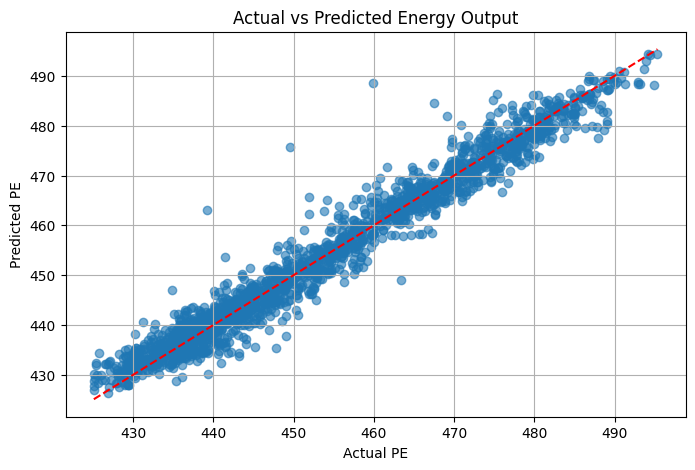

In [14]:
# %% [markdown]
# ## 📊 Visualization: Actual vs Predicted

# %%
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual PE")
plt.ylabel("Predicted PE")
plt.title("Actual vs Predicted Energy Output")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid()
plt.show()